# **Install Dependencies**

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [ ]:
!pip install sacrebleu  rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.8 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=996148d28fdd25318fca4073dca029f35de0b11ecc04dccfd0a536dbcd9d51f2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


# **Import Libraries**

In [ ]:
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainerCallback,
)
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
from rouge_score import rouge_scorer
import json
import glob
import time
import unicodedata
import re
import nltk
import warnings
warnings.filterwarnings('ignore')

2025-05-03 14:41:27.439891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746283287.744228      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746283287.826007      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Analysis and Cleaning**

In [ ]:
df = pd.read_parquet("hf://datasets/damerajee/english-to-hindi-l/data/train-00000-of-00001.parquet")

In [ ]:
df.head()

,english_sentence,hindi_sentence
0,When it is said to him: 'Fear Allah' egotism t...,"और जब उससे कहा जाता है, ""अल्लाह से डर"", तो अहं..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से (भी) पहले वे धु...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786788 entries, 0 to 1786787
Data columns (total 2 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   english_sentence  object
 1   hindi_sentence    object
dtypes: object(2)
memory usage: 27.3+ MB


In [ ]:
df.isnull().sum()

english_sentence    0
hindi_sentence      0
dtype: int64

In [ ]:
df.duplicated().sum()

238016

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
len(df)

1548772

In [ ]:
def clean(text: str) -> str:
    text = unicodedata.normalize("NFKC", text)

    text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')

    text = re.sub(r'\d+', '', text)

    # Keep English, Hindi (Devanagari block), basic punctuation, and whitespace
    text = re.sub(r'[^\w\s\u0900-\u097F.,!?;:]', '', text)

    text = re.sub(r'\s+', ' ', text)

    return text.strip()
df['english_sentence']=df['english_sentence'].apply(clean)
df['hindi_sentence']=df['hindi_sentence'].apply(clean)

In [ ]:
df.head(10)

,english_sentence,hindi_sentence
0,When it is said to him: Fear Allah egotism tak...,"और जब उससे कहा जाता है, अल्लाह से डर, तो अहंका..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से भी पहले वे धुएँ...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...
5,"Have you then considered Al Lat, and Al Uzza t...",तो क्या तुमने लात और उज़्ज़ा
6,Escalation in demand will provide traders an o...,मांग में वृद्धि व्यापारियों को कीमतें बढाने का...
7,He understood the pity and the beauty of life ...,वे जीवन में अनुकम्पा और सौन्दर्य के महत्व को स...
8,Fast Track Court The Additional Sessions Court...,फास्ट ट्रेक कोर्टये अतिरिक्त सत्र न्यायालय है ...
9,He was working as a quality controller in the ...,वह खाद्य उत्पादन कारखाने में गुणवत्ता नियंत्रक...


# **Data Preparation**

* Data Splitting

In [ ]:
df['total_length'] = df['english_sentence'].str.len() + df['hindi_sentence'].str.len()
df = df.sort_values(by='total_length', ascending=False).head(30000).reset_index(drop=True)
df.drop(columns='total_length', inplace=True)

train_df = df.iloc[:25000]
val_df = df.iloc[25000:27000]
test_df = df.iloc[27000:30000]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 25000 rows
Validation set: 2000 rows
Test set: 3000 rows


* Model and Tokenizer Initialization

In [ ]:
device = "cuda:0"
model_name="Helsinki-NLP/opus-mt-en-hi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name ,
                                              torch_dtype=torch.float16,
                                             )
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
devices = set(param.device for param in model.parameters())
print(f"Model parameters are on devices: {devices}")

Model parameters are on devices: {device(type='cuda', index=0)}


In [ ]:
if len(devices) > 1:
    print("WARNING: Parameters are on different devices. Forcing all to same device...")
    for param in model.parameters():
        param.data = param.data.to(device)

    devices = set(param.device for param in model.parameters())
    print(f"After fixing, model parameters are on devices: {devices}")

for buffer_name, buffer in model.named_buffers():
    buffer.data = buffer.data.to(device)

In [ ]:
print(f"Number of encoder layers: {len(model.model.encoder.layers)}")
print(f"Number of decoder layers: {len(model.model.decoder.layers)}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/all_params:.2%})")

Number of encoder layers: 6
Number of decoder layers: 6
Trainable parameters: 76,381,184 (100.00%)


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

* Data Preprocessing

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
def preprocess_function(examples):
    inputs = examples["english_sentence"]
    targets = examples["hindi_sentence"]

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
import os
!mkdir /kaggle/working/results
!mkdir /kaggle/working/results/best
!mkdir /kaggle/working/models

# **Callbacks - Helper Functions**

* Available Training Parameters  - Version-based

In [ ]:
try:
    import inspect
    print("Available parameters for Seq2SeqTrainingArguments:")
    sig = inspect.signature(Seq2SeqTrainingArguments.__init__)
    print(list(sig.parameters.keys()))
except Exception as e:
    print(f"Couldn't inspect parameters: {e}")

Available parameters for Seq2SeqTrainingArguments:
['self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 

* Evaluation Metrics

In [ ]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    bleu_result = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )

    rouge_result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    result = {
        "bleu": bleu_result["bleu"],
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
    }

    return result

* In-Training Evaluation Callbacks

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

class PrintEpochCallback(TrainerCallback):
    def __init__(self):
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        print(f"Starting Epoch {state.epoch:.2f}")

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.epoch_start_time:
            duration = time.time() - self.epoch_start_time
            print(f"Epoch {state.epoch-1:.2f} time: {duration:.2f} seconds")

class MemoryCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"[Step {state.global_step}] Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB")

class EvalEveryNStepsCallback(TrainerCallback):
    def __init__(self, eval_steps=500):
        self.eval_steps = eval_steps

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.eval_steps == 0 and state.global_step != 0:
            control.should_evaluate = True
        if state.global_step == state.max_steps:
            control.should_evaluate = True

        return control

In [ ]:
import os
os.environ["WANDB_MODE"] = "offline"

# **Hyperparameters Tuning Results**

**Best Parameters:**

- **Learning Rate:** `5e-5`  
- **Batch Size:** `16`  
- **Weight Decay:** `0.1`  

**With the highest BLEU score**

In [ ]:
bleu_scores=[0.22339202001245728,
 0.221905513730126,
 0.18329391890145863,
 0.1606352694831102,
 0.1499672434033014,
 0.14022739767406409,
 0.13878820433054403,
 0.13549504808218785,
 0.13480571919233808,
 0.1305758889213967,
 0.12746379796699628,
 0.12519726387783076]

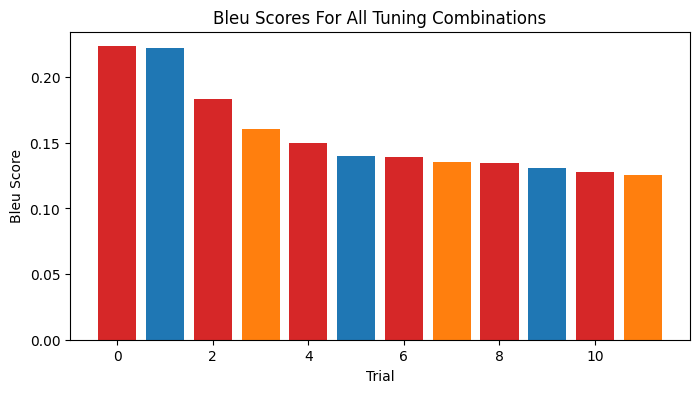

In [ ]:
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
plt.figure(figsize=(8, 4))
plt.bar(range(len(bleu_scores)), bleu_scores, color=bar_colors)
plt.xlabel("Trial")
plt.ylabel("Bleu Score")
plt.title("Bleu Scores For All Tuning Combinations")
plt.show()

In [ ]:
best_params={
    "learning_rate":5e-5,
    'batch_size':16,
    "weight_decay":0.1,
}

# **Training Using Best Parameters + Mixed Precision**

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/results/best",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    predict_with_generate=True,
    learning_rate=best_params['learning_rate'],
    max_grad_norm=0.5,
    weight_decay=best_params['weight_decay'],
    adam_beta1=0.95,
    num_train_epochs=25,
    save_steps=100,
    save_total_limit=1,
    fp16=True,
    fp16_full_eval=True,
    # deepspeed=None,
    # fsdp=None,
    # local_rank=-1,
    dataloader_num_workers=0,
    generation_num_beams=5,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EvalEveryNStepsCallback(eval_steps=1000),
               PrintEpochCallback,
               MemoryCallback,
              ],
)

In [ ]:
print('Starting Fine Tuning......')
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Starting Fine Tuning......


wandb: Tracking run with wandb version 0.19.6
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Starting Epoch 0.00


Epoch 0.00 time: 140.23 seconds
[Step 782] Allocated: 0.44 GB | Reserved: 2.27 GB
Starting Epoch 1.00
Epoch 1.00 time: 159.08 seconds
[Step 1564] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 2.00
Epoch 2.00 time: 158.27 seconds
[Step 2346] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 3.00
Epoch 3.00 time: 158.07 seconds
[Step 3128] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 4.00
Epoch 4.00 time: 140.34 seconds
[Step 3910] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 5.00
Epoch 5.00 time: 157.00 seconds
[Step 4692] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 6.00
Epoch 6.00 time: 158.38 seconds
[Step 5474] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 7.00
Epoch 7.00 time: 158.84 seconds
[Step 6256] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 8.00
Epoch 8.00 time: 158.20 seconds
[Step 7038] Allocated: 0.45 GB | Reserved: 2.27 GB
Starting Epoch 9.00
Epoch 9.00 time: 140.82 seconds
[Step 7820] Allocated: 0.45 GB | Reserved:

TrainOutput(global_step=19550, training_loss=0.05525735294117647, metrics={'train_runtime': 3859.8773, 'train_samples_per_second': 161.922, 'train_steps_per_second': 5.065, 'total_flos': 2.118647808e+16, 'train_loss': 0.05525735294117647, 'epoch': 25.0})

# **Results Visualization**

In [ ]:
base_path = "/kaggle/working/results/best"
checkpoints = glob.glob(os.path.join(base_path, "checkpoint-*"))
checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))
latest_checkpoint = checkpoints[-1]
log_path = os.path.join(latest_checkpoint, "trainer_state.json")

with open(log_path, "r") as f:
    state = json.load(f)

log_history = state["log_history"]

# Convert to DataFrame
df_logs = pd.DataFrame(log_history)

In [ ]:
df_logs.head()

,epoch,grad_norm,learning_rate,loss,step,eval_bleu,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.639386,NaN,0.000049,2.1606,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.278772,NaN,0.000047,0.0000,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.278772,NaN,NaN,NaN,1000,0.0,NaN,0.0,0.0,0.0,18.7061,106.917,3.368


In [ ]:
 df_logs["eval_bleu"]

0    NaN
1    NaN
2    0.0
Name: eval_bleu, dtype: float64

In [ ]:
 df_logs["loss"]

0    2.1606
1    0.0000
2       NaN
Name: loss, dtype: float64

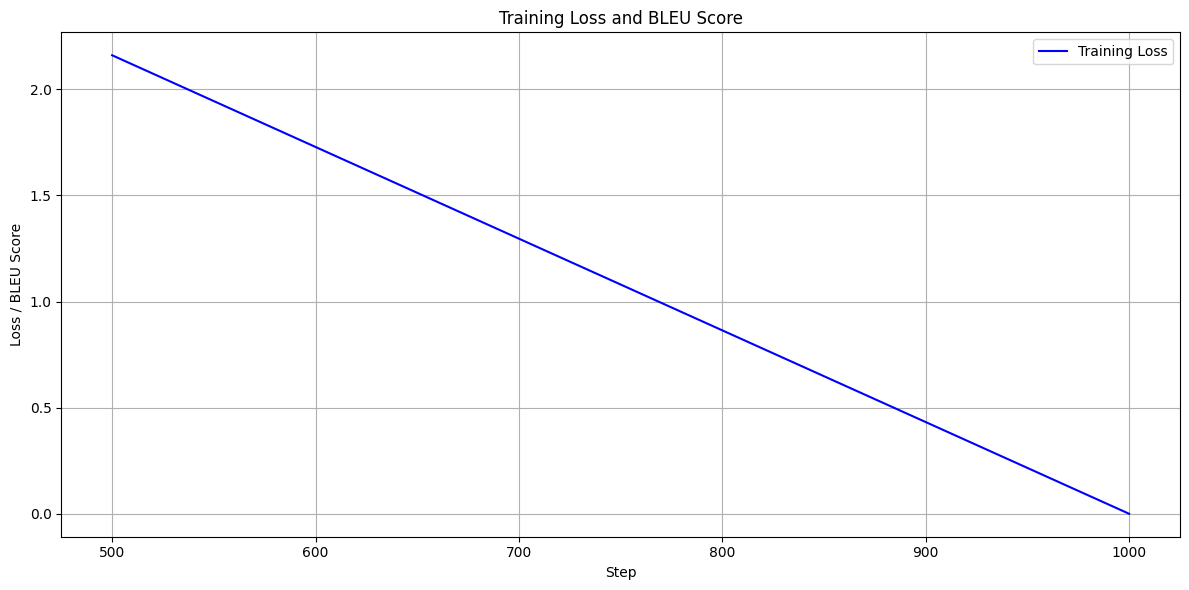

In [ ]:
plt.figure(figsize=(12, 6))

# Training Loss
plt.plot(df_logs.dropna(subset=["loss"])["step"],
         df_logs.dropna(subset=["loss"])["loss"], label="Training Loss", color="blue")
plt.xlabel("Step")
plt.ylabel("Loss / BLEU Score")
plt.title("Training Loss and BLEU Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

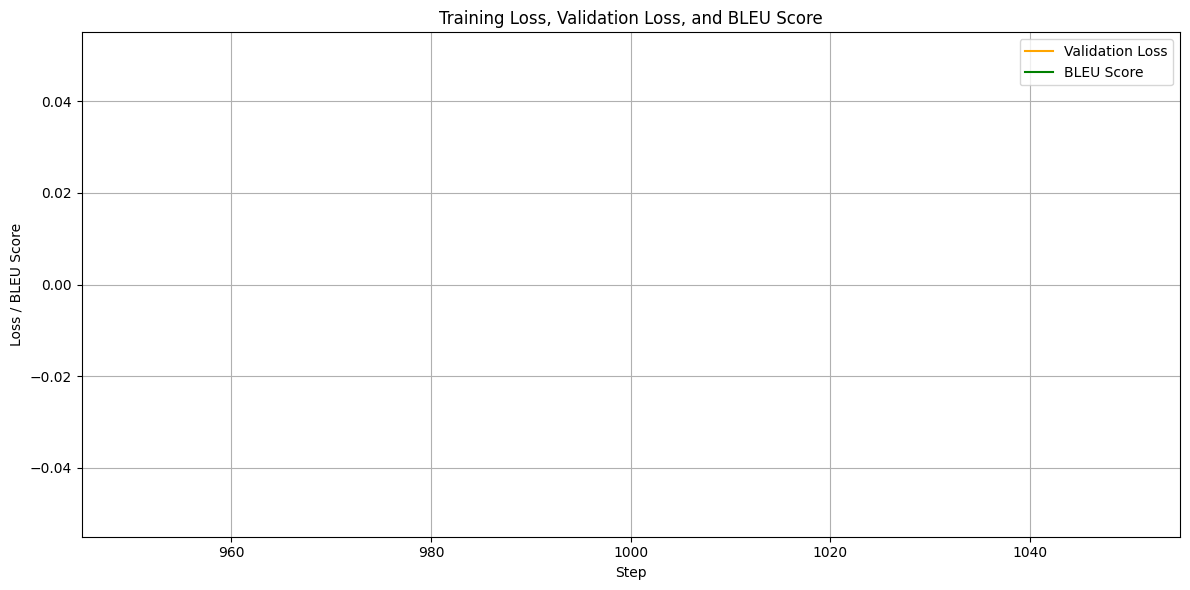

In [ ]:
plt.figure(figsize=(12, 6))

# Validation Loss
plt.plot(df_logs.dropna(subset=["eval_loss"])["step"],
         df_logs.dropna(subset=["eval_loss"])["eval_loss"],
         label="Validation Loss", color="orange")

# BLEU Score
plt.plot(df_logs.dropna(subset=["eval_bleu"])["step"],
         df_logs.dropna(subset=["eval_bleu"])["eval_bleu"],
         label="BLEU Score", color="green")

plt.xlabel("Step")
plt.ylabel("Loss / BLEU Score")
plt.title("Training Loss, Validation Loss, and BLEU Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

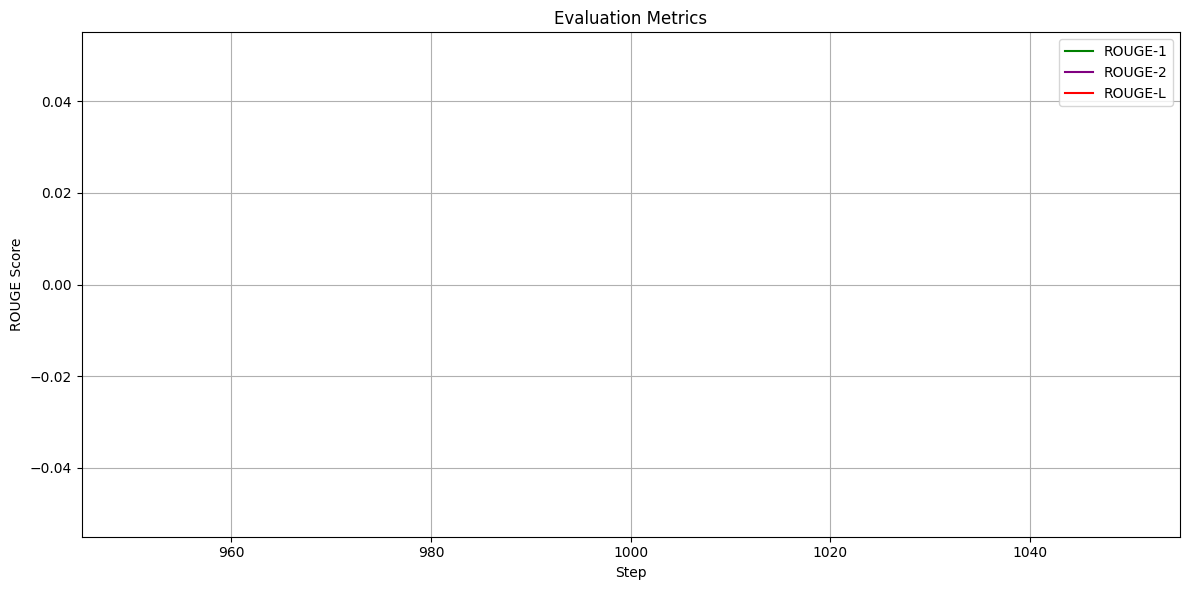

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_logs.dropna(subset=["eval_rouge1"])["step"],
         df_logs.dropna(subset=["eval_rouge1"])["eval_rouge1"],
         label="ROUGE-1", color="green")

plt.plot(df_logs.dropna(subset=["eval_rouge2"])["step"],
         df_logs.dropna(subset=["eval_rouge2"])["eval_rouge2"],
         label="ROUGE-2", color="purple")

plt.plot(df_logs.dropna(subset=["eval_rougeL"])["step"],
         df_logs.dropna(subset=["eval_rougeL"])["eval_rougeL"],
         label="ROUGE-L", color="red")

plt.xlabel("Step")
plt.ylabel("ROUGE Score")
plt.title("Evaluation Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# **Evaluation and Inference**

In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': nan, 'eval_bleu': 0.0, 'eval_rouge1': 0.0, 'eval_rouge2': 0.0, 'eval_rougeL': 0.0, 'eval_runtime': 17.7894, 'eval_samples_per_second': 112.427, 'eval_steps_per_second': 3.541, 'epoch': 25.0}


In [ ]:
# Predict
predictions = trainer.predict(test_dataset)
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

label_ids = predictions.label_ids
label_ids[label_ids == -100] = tokenizer.pad_token_id  # or just 0
decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

results = rouge_metric.compute(predictions=[" ".join(pred.split()) for pred in decoded_preds],
                                references=[[" ".join(ref.split())] for ref in decoded_labels])
for key in results:
    print(f"{key}: {results[key]:.4f}")

bleu_score = bleu_metric.compute(predictions=[" ".join(pred.split()) for pred in decoded_preds],
                          references=[[" ".join(ref.split())] for ref in decoded_labels])
print(f"BLEU: {bleu_score['bleu']:.4f}")

rouge1: 0.0000
rouge2: 0.0000
rougeL: 0.0000
rougeLsum: 0.0000
BLEU: 0.0000


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

input_sentence = "hello guys"
inputs = tokenizer(input_sentence, return_tensors="pt", truncation=True, padding=True)

inputs = {key: value.to(device) for key, value in inputs.items()}

outputs = model.generate(**inputs)

decoded_pred = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"English: {input_sentence} => Predicted Translation: {decoded_pred}")

English: hello guys => Predicted Translation: के


In [ ]:
input_sentence = "Artificial intelligence is transforming the way we live and work. It is enabling machines to learn from data, make decisions, and even improve themselves over time. As AI technology advances, it holds the potential to solve complex problems in various fields, from healthcare to education, and beyond. However, it also brings challenges, such as ethical concerns and job displacement, that need to be addressed carefully."

reference_translation = "आर्टिफिशियल इंटेलिजेंस हमारे जीने और काम करने के तरीके को बदल रहा है। यह मशीनों को डेटा से सीखने, निर्णय लेने और समय के साथ खुद को बेहतर बनाने में सक्षम बना रहा है। जैसे-जैसे एआई तकनीक आगे बढ़ रही है, इसमें स्वास्थ्य सेवा से लेकर शिक्षा तक और उससे आगे के विभिन्न क्षेत्रों में जटिल समस्याओं को हल करने की क्षमता है। हालांकि, यह नैतिक चिंताओं और नौकरियों के नुकसान जैसी चुनौतियाँ भी लेकर आता है, जिन्हें सावधानीपूर्वक संबोधित करना आवश्यक है।"
inputs = tokenizer(input_sentence, return_tensors="pt", truncation=True, padding=True)

inputs = {key: value.to(device) for key, value in inputs.items()}
outputs = model.generate(**inputs)

predicted_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Input for Translation: {input_sentence}")
print('=============================')
print(f"Reference Translation: {reference_translation}")
print('=============================')
print(f"Predicted Translation: {predicted_translation}")
print('=============================')

formatted_pred = [" ".join(predicted_translation.split())]  # Predicted sentence
formatted_ref = [[" ".join(reference_translation.split())]]  # Reference translation

bleu_score = bleu_metric.compute(predictions=formatted_pred, references=formatted_ref)
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print('=============================')

rouge_score = rouge_metric.compute(predictions=formatted_pred, references=formatted_ref)

for key in rouge_score:
    print(f"{key}: {rouge_score[key]:.4f}")

Input for Translation: Artificial intelligence is transforming the way we live and work. It is enabling machines to learn from data, make decisions, and even improve themselves over time. As AI technology advances, it holds the potential to solve complex problems in various fields, from healthcare to education, and beyond. However, it also brings challenges, such as ethical concerns and job displacement, that need to be addressed carefully.
Reference Translation: आर्टिफिशियल इंटेलिजेंस हमारे जीने और काम करने के तरीके को बदल रहा है। यह मशीनों को डेटा से सीखने, निर्णय लेने और समय के साथ खुद को बेहतर बनाने में सक्षम बना रहा है। जैसे-जैसे एआई तकनीक आगे बढ़ रही है, इसमें स्वास्थ्य सेवा से लेकर शिक्षा तक और उससे आगे के विभिन्न क्षेत्रों में जटिल समस्याओं को हल करने की क्षमता है। हालांकि, यह नैतिक चिंताओं और नौकरियों के नुकसान जैसी चुनौतियाँ भी लेकर आता है, जिन्हें सावधानीपूर्वक संबोधित करना आवश्यक है।
Predicted Translation: के
BLEU Score: 0.0000
rouge1: 0.0000
rouge2: 0.0000
rougeL: 0.0000
r

# **Save Training Results**

In [ ]:
save_path = "/kaggle/working/models"

In [ ]:
trainer.save_model(save_path)
trainer.save_state()
tokenizer.save_pretrained(save_path)

('/kaggle/working/models/tokenizer_config.json',
 '/kaggle/working/models/special_tokens_map.json',
 '/kaggle/working/models/vocab.json',
 '/kaggle/working/models/source.spm',
 '/kaggle/working/models/target.spm',
 '/kaggle/working/models/added_tokens.json')

In [ ]:
trainer.state.save_to_json(f"{save_path}/trainer_state.json")

In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained(save_path)
model2 = AutoModelForSeq2SeqLM.from_pretrained(save_path)

In [ ]:
input_text = "Translate English to Hindi: How are you?"

inputs = tokenizer2(input_text, return_tensors="pt")

output_tokens = model2.generate(
    **inputs,
    max_length=50,
    num_beams=4,
    early_stopping=True
)

output_text = tokenizer2.decode(output_tokens[0], skip_special_tokens=True)

print("Output:", output_text)

Output: 
